This code ingests:
    
- A set of photos (e.g. `photos/png1600` or `depth/png320`)

And outputs:

- A `.npy` file or a set of `.jpg` or `.png` images containing resized and cropped versions of the images.

This notebook also shows a preview of the resized images in a grid of small multiples when saving .npy files.

In [134]:
from utils.imutil import *
from utils.list_all_files import *
from utils.crop import *
from utils.progress import *
from utils.mosaic import *
import os
import re

In [135]:
input_dir = '../data/photos/png1600'
output_dir = '../data/photos/npy32'

# input_dir = '../data/detectron/png1600'
# output_dir = '../data/detectron/npy32'

# input_dir = '../data/depth/png320'
# output_dir = '../data/depth/npy32'

# input_dir = '../data/saliency/jpg640'
# output_dir = '../data/saliency/npy32'

# input_dir = '../data/openface/jpg640-ellipses'
# output_dir = '../data/openface/npy32-ellipses'

output_fmt = '.npy' # .jpg, .png, .npy
output_side = 32
max_n = None #256

# crop = outer_square_crop
crop = inner_square_crop
# crop = None

covert_to_grayscale = True # False
output_dtype = np.uint8 # None

59278 0:01:14 801.70/s


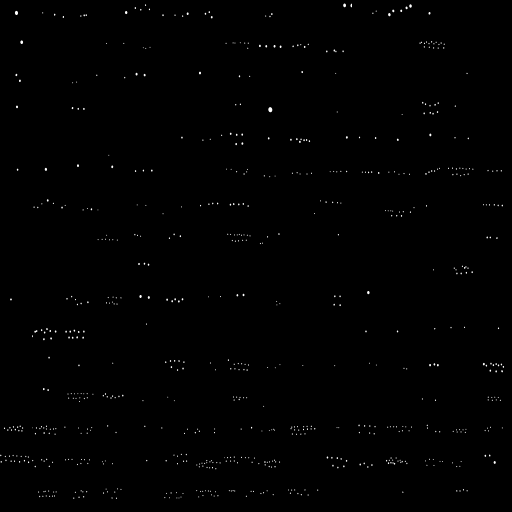

In [136]:
def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
    return [int(text) if text.isdigit() else text.lower()
            for text in _nsre.split(s)]

def get_id(fn):
    return os.path.splitext(os.path.basename(fn))[0]

def job(task):
    try:
        input_fn, output_fn = task
        img = imread(input_fn)
        if crop is not None:
            img = crop(img)
        img = imresize(img, max_side=output_side)
        if covert_to_grayscale and len(img.shape) == 3:
            img = img.mean(axis=2)
        if output_dtype is not None:
            img = img.astype(output_dtype)
        if output_fmt == '.npy':
            return img
        else:
            imwrite(output_fn, img)
            return img.shape
    except:
        print('Error:', input_fn)
        raise

tasks = []
for input_fn in list_all_files(input_dir):
    relpath = os.path.relpath(input_fn, input_dir)
    reldir = os.path.split(relpath)[0]
    if output_fmt == '.npy':
        tasks.append((input_fn, relpath))
    else:
        output_fn = os.path.join(output_dir, os.path.splitext(relpath)[0] + output_fmt)
        os.makedirs(os.path.split(output_fn)[0], exist_ok=True)
        tasks.append((input_fn, output_fn))
        
tasks.sort(key=lambda x: natural_sort_key(get_id(x[0])))

if max_n is not None:
    tasks = tasks[:max_n]

results = progress_parallel(job, tasks)

if output_fmt == '.npy':
    images = np.asarray(results)
    imshow(make_mosaic(images[:256]))
    
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, 'images.npy'), images)